In [1]:
import numpy as np
import pandas as pd
from cmdstanpy import CmdStanModel
from matplotlib import pyplot as plt

# Load and plot data

In [2]:
Y = np.genfromtxt("data/data-2Dmesh.txt", delimiter=",")
TID = np.genfromtxt("data/data-2Dmesh-design.txt", delimiter=",", dtype="int")

In [3]:
Y.shape, TID.shape

((16, 24), (16, 24))

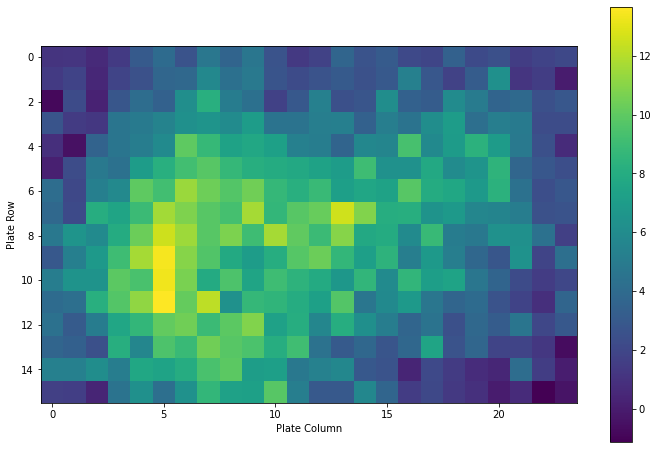

In [4]:
# Fig 12.8
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot()
ax.set_xlabel("Plate Column")
ax.set_ylabel("Plate Row")
fig.colorbar(ax.imshow(Y))
fig.show()

# Run stan

In [5]:
#model= CmdStanModel(stan_file="model/model12-13.stan")
model= CmdStanModel(stan_file="model/model12-13b.stan")
print(model)

INFO:cmdstanpy:compiling stan program, exe file: /workdir/chapter12/model/model12-13b
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /workdir/chapter12/model/model12-13b


CmdStanModel: name=model12-13b
	 stan_file=/workdir/chapter12/model/model12-13b.stan
	 exe_file=/workdir/chapter12/model/model12-13b
	 compiler_optons=stanc_options=None, cpp_options=None


In [6]:
I = Y.shape[0] # 16
J = Y.shape[1] # 24
T = 96

data = {
    "I": I,
    "J": J,
    "Y": Y,
    "T": T,
    "TID": TID
}

In [7]:
fit = model.sample(data=data)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4


In [8]:
summary = fit.summary()
summary[summary["R_hat"] >= 1.1]

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,


# Plot result

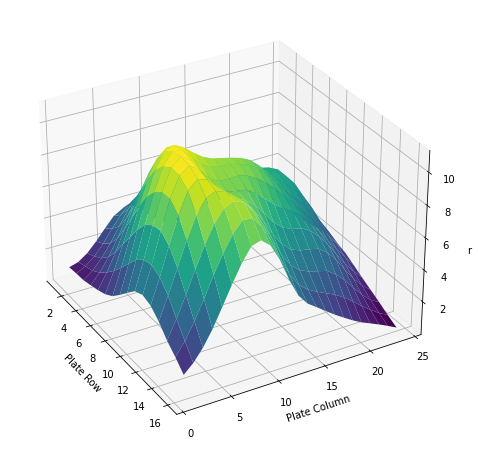

In [9]:
# Figure 12.9 left
r_median = np.median(fit.stan_variable("r"), axis=0)

y = np.arange(1, 25, 1)
x = np.arange(1, 17, 1)
x, y = np.meshgrid(x, y)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(projection="3d", azim=-30, elev=30)
ax.plot_surface(x, y, r_median.transpose(), cmap="viridis")
ax.set_xlabel("Plate Row")
ax.set_ylabel("Plate Column")
ax.set_zlabel("r")
fig.show()

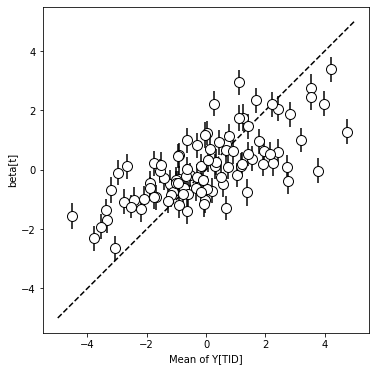

In [10]:
# Figure 12.9 right

Y_mean = Y.mean()
Y_t = np.zeros(T)
count_t = np.zeros(T)
for i in range(I):
    for j in range(J):
        Y_t[TID[i,j]-1] += Y[i,j]
        count_t[TID[i,j]-1] += 1        
for t in range(T):
    Y_t[t] = Y_t[t] / count_t[t] - Y_mean
    
beta_percentiles = np.percentile(fit.stan_variable("beta"), [2.5, 50.0, 97.5], axis=0)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot()
ax.plot([-5.0, 5.0], [-5.0, 5.0], "k--")
ax.errorbar(
    x=Y_t, 
    y=beta_percentiles[1], 
    yerr=np.abs(beta_percentiles[[0, 2]] - beta_percentiles[1]),
    fmt="o",
    ecolor='k',
    markerfacecolor='w',
    markeredgecolor='k',
    markersize=10
)
ax.set_xlim(-5.5, 5.5)
ax.set_ylim(-5.5, 5.5)
ax.set_aspect("equal")
ax.set_xlabel("Mean of Y[TID]")
ax.set_ylabel("beta[t]")
fig.show()